In [1]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.6 MB/s eta 0:00:00


Epoch 1/5
582/582 [==============================] - 132s 221ms/step - loss: 0.7418 - accuracy: 0.5227 - val_loss: 0.6369 - val_accuracy: 0.6324
Epoch 2/5
582/582 [==============================] - 121s 208ms/step - loss: 0.5908 - accuracy: 0.6879 - val_loss: 0.5122 - val_accuracy: 0.7451
Epoch 3/5
582/582 [==============================] - 147s 253ms/step - loss: 0.4712 - accuracy: 0.7772 - val_loss: 0.4626 - val_accuracy: 0.7820
Epoch 4/5
582/582 [==============================] - 120s 206ms/step - loss: 0.3944 - accuracy: 0.8247 - val_loss: 0.4447 - val_accuracy: 0.7954
Epoch 5/5
582/582 [==============================] - 119s 204ms/step - loss: 0.3114 - accuracy: 0.8720 - val_loss: 0.4581 - val_accuracy: 0.8074


Adversarial Test Accuracy: 0.00%


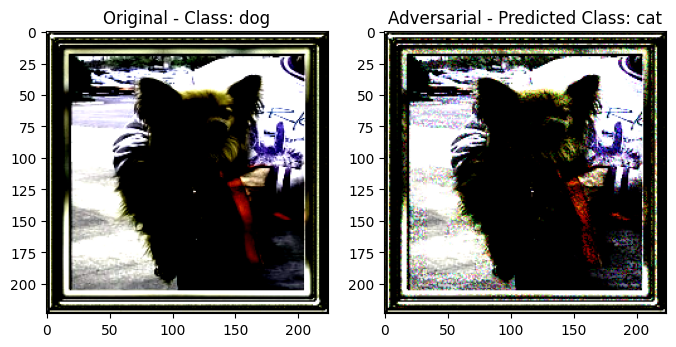

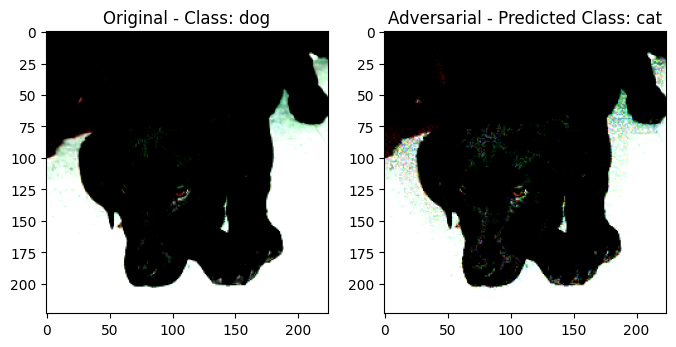

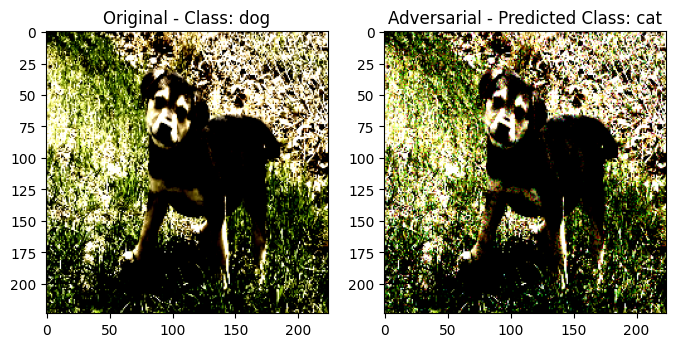

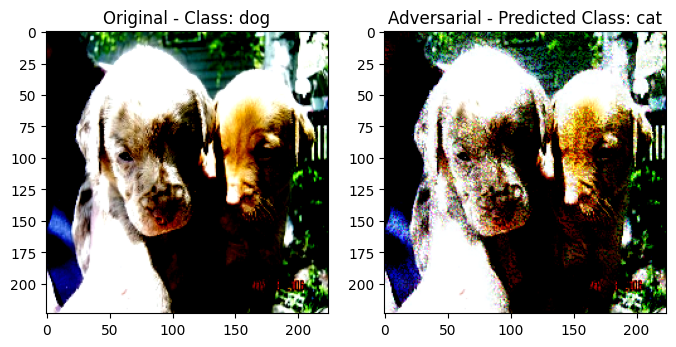

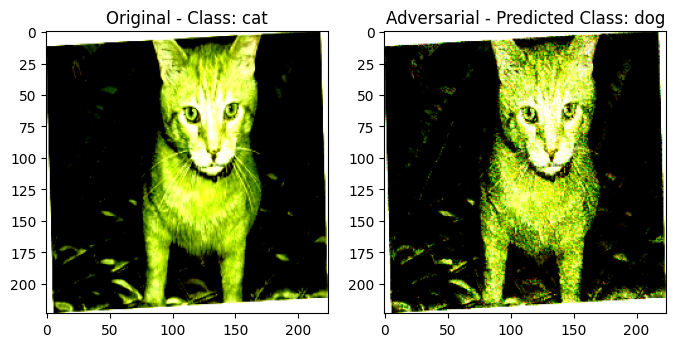

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, dataset_info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=True)
num_classes = 2
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = dataset_info.splits['train'].num_examples
num_train_samples = int(0.8 * num_samples)
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples
train_dataset = dataset.take(num_train_samples)
remaining_dataset = dataset.skip(num_train_samples)
val_dataset = remaining_dataset.take(num_val_samples)
test_dataset = remaining_dataset.skip(num_val_samples)
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
class_names = dataset_info.features['label'].names
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#GAN
model.fit(train_dataset, epochs=5, validation_data=val_dataset)
generator = Sequential([
    layers.Dense(256, activation='relu', input_shape=(100,)),
    layers.Reshape((4, 4, 16)),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
])
discriminator = Sequential([
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.2)
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
num_adversarial_images = adversarial_test_images.shape[0]
print(f"Number of Adversarial Images: {num_adversarial_images}")
num_display = min(num_adversarial_images, 5)
for i in range(num_display):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title(f'Original - Class: {class_names[test_labels[i].numpy()]}')
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial - Predicted Class: {class_names[np.argmax(art_classifier.predict(adversarial_test_images[i][tf.newaxis, ...]))]}')
    plt.show()
    #Here we are looking at the original class and also the predicted class using GAN and ART which allowed to combine them both together, we are able to see that it is sucessfully confusing the AI model.
